In [2]:
# import os
import cv2
import numpy as np
import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.python.keras.utils.vis_utils import plot_model
import pandas as pd
import argparse
from sklearn.model_selection import train_test_split
import pickle

def label(df,x_data,y_data):
    #label data
    y_data.append(df[1])
    #image data
    image = cv2.imread('./images/20200805_02/'+df[0])

    # 이미지를 BGR 형식에서 RGB 형식으로 변환
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 이미지 축소
#     image = cv2.resize(image, (256,256), interpolation=cv2.INTER_AREA)
    # 이미지 배열(RGB 이미지)
    x_data.append(np.array(image))


# 파일 불러오기
def load_label_images(csv_path):
    data = pd.read_csv(csv_path)
    print(data.head())

    #x,y 데이터 만들기
    X = []
    Y = []
    data.apply(lambda df: label(df,X,Y),axis=1)
    X = np.array(X)
    Y = np.array(Y)
    
    return (X, Y)

X, Y=load_label_images('images/20200805_02_FLabel.csv')

                          0  1
0  2018_0203_171537_042.JPG  0
1  2018_0203_171618_056.JPG  0
2  2018_0203_171519_036.JPG  0
3  2018_0203_171637_062.JPG  0
4  2018_0203_171622_057.JPG  1


In [3]:
X.shape

(55, 3024, 4032, 3)

In [4]:
Y.shape

(55,)

In [9]:
import os 

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=100)
    
#test data 따로 보관하기 
# try:
#     os.remove('X_test.bin')
#     os.remove('Y_test.bin')
# except:
#     pass
# with open('X_test.bin','wb') as f:
#     pickle.dump(X_test,f)
# with open('Y_test.bin','wb') as f:
#     pickle.dump(Y_test,f)

##LOAD 할때는 이렇게
# with open('X_test.bin','rb') as f:
#     pickle.load(f)
# with open('Y_test.bin','rb') as f:
#     pickle.load(f)

# 모델정의
model = Sequential()
#CNN-1
model.add(Conv2D(
    input_shape=X.shape[1:],  #(3024, 4032, 3)
    filters=128,
    kernel_size=(8,8),
    strides=(3,3),
    padding="same",
    activation='relu',
))
model.add(MaxPooling2D(pool_size=(3, 3)))
#cnn-2
model.add(Conv2D(
    filters=64,
    kernel_size=(8,8),
    strides=(2,2),
    padding="same",
    activation='relu',
))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.02))
#cnn-3
model.add(Conv2D(
    filters=32,
    kernel_size=(8,8),
    strides=(2,2),
    padding="same",
    activation='relu',
))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.02))
# fully-connected
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='softmax'))


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 1008, 1344, 128)   24704     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 336, 448, 128)     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 168, 224, 64)      524352    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 74, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 56, 74, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 37, 32)        131104    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 9, 12, 32)        

In [10]:
X_train[0].shape

(3024, 4032, 3)

In [ ]:
#compile
model.compile(optimizer='adam',
loss = 'BinaryCrossentropy',
metrics= ['accuracy'],
)

#parameter
batch_size = 32
epochs = 30

OUTPUT_MODEL_DIR = 'model/'
# history = model.fit(X_train, Y_train, 
#                 batch_size=batch_size, epochs=epochs, 
#                 validation_data=(X_test, Y_test),verbose=0)

history=model.fit(X_train, Y_train, epochs=epochs,batch_size=batch_size,verbose=0,validation_data=(X_test, Y_test))
test_loss, test_acc = model.evaluate(X_test, Y_test,batch_size=batch_size,verbose=0)
print(f"validation loss:{test_loss}")
print(f"validation accuracy:{test_acc}")
# 모델 저장
model_file_path = os.path.join(OUTPUT_MODEL_DIR, 'model.h5')
model.save(model_file_path)

In [ ]:
X_test[0].shape

In [54]:
result=model.predict(np.expand_dims(X_test[0],axis=0))[0]

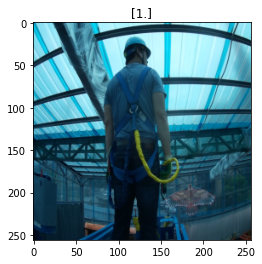

In [61]:
import matplotlib.pyplot as plt
testdata = X_test[7]
plt.imshow(testdata)
plt.title(model.predict(np.expand_dims(testdata,axis=0))[0])
plt.show()

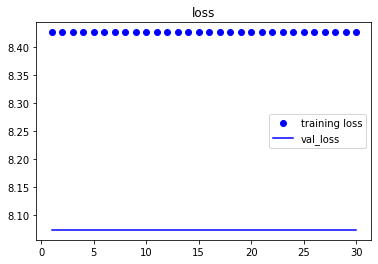

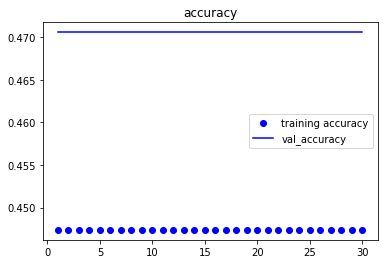

In [64]:
#include loss, accuracy, val_loss, val_accuracy 
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss)+1)

plt.plot(epochs,loss,'bo', label='training loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('loss')
plt.legend()

plt.figure()
plt.plot(epochs,accuracy,'bo', label='training accuracy')
plt.plot(epochs,val_accuracy,'b', label='val_accuracy')
plt.title('accuracy')
plt.legend()
plt.show()